<a href="https://colab.research.google.com/github/luisdiaz1997/BiomedicalNN/blob/master/FastChest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#We want to delete the current Pytorch and reinstall torch ==1.4.0

In [0]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/90/6141bf41f5655c78e24f40f710fdd4f8a8aff6c8b7c6f0328240f649bdbe/torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl


##import FastAI

In [0]:
import fastai
from fastai.vision import *

## Set up Kaggle

In [0]:
! pip install -q kaggle
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Put your Json file into files then run the following block

In [0]:
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#We will be using the Chest-xray dataset

In [0]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 20.1MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.6MB/s]


## We want to unzip the data

In [0]:
!unzip chest-xray-pneumonia.zip

## We load the data from folder, we use test as our validation given that val only contains 16 images, and test contains 624

### We also transform it into a 128 x 128, and select a batch size of 32, also apply some transfomations for data augmentation and normalize the data with parameters used for the image_net dataset


In [9]:
data = ImageDataBunch.from_folder(path = '/content/chest_xray', train = 'train', 
                                  valid = 'test', 
                                  size=128,bs=32, ds_tfms=get_transforms()).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (5216 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /content/chest_xray;

Valid: LabelList (624 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: /content/chest_xray;

Test: None

## Proceed to create a label_dict, to just for us to display the images later

In [158]:
label_dict = dict()
for key, val in data.label_list.train.y.c2i.items():
  label_dict[val] = key

label_dict

{0: 'NORMAL', 1: 'PNEUMONIA'}

## FastAi has this .show_batch() which lets you explore the internals of your data

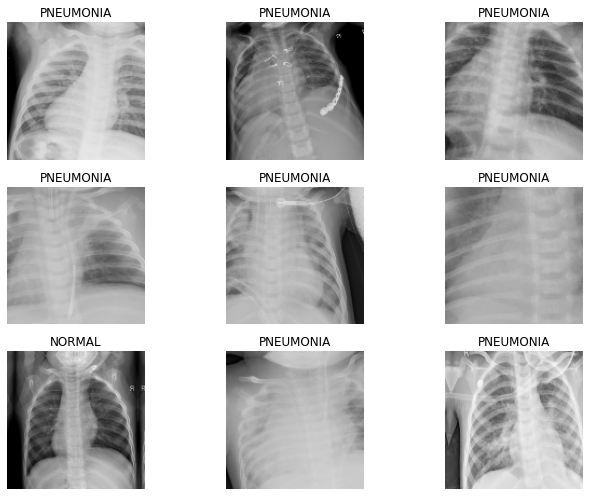

In [11]:
data.show_batch(3, figsize=(10,7));

#We try to load the learner first, if available, otherwise we can just create a new one.

### This model will be using Dense121, but you can try other popular pretrained networks such resnet18

### We also make use of AUROC score, since accuracy is not necessarily a good metric, AUROC takes into account false positives and true positives for score calculation

In [64]:
try:
  
  
  learn = load_learner(path = '/content/', file = 'dense')
  learn.data = data
  print("dense model imported")
except:
  learn = cnn_learner(data, models.densenet121, 
                   metrics=[accuracy, AUROC()],
                   model_dir='/content/')
  print("created new model")

dense model imported


## We first find the learning rate with the he lowest slope, meaning that this one will contain the minimum gradient.

In [50]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.20E-02


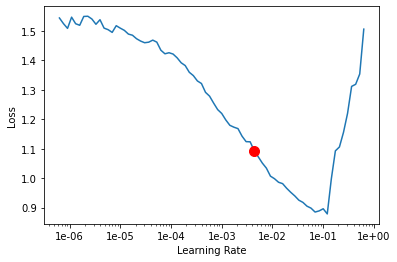

In [52]:
learn.recorder.plot(suggestion= True)

## We train for 2 cycles

In [53]:
learn.fit_one_cycle(2, 4.37E-03)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.250980,0.514355,0.846154,0.915954,02:44
1,0.107944,0.324475,0.895833,0.956542,02:44


## We save the model

### I called it dense, but feel free to use any other name

In [0]:
learn.export('/content/dense')

## Optional, you can also UNFREEZE the model, so it trains all the layers, not only the latest ones. This is useful to finetune your model

In [0]:

'''
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4, 1e-3))
'''

## Let's take a look at how the bad predictions look like

In [69]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

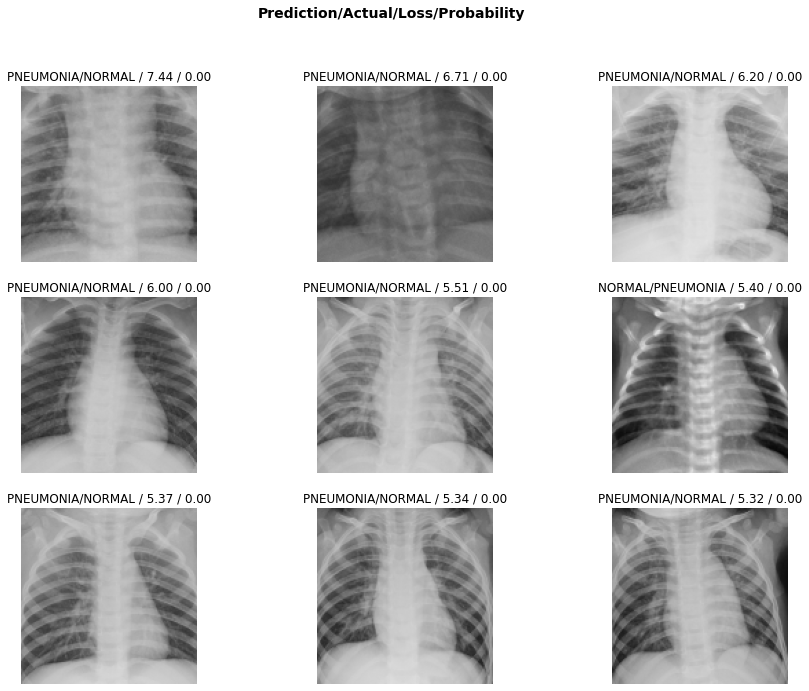

In [73]:
interp.plot_top_losses(9, figsize=(15,11))

#Let's predict on single images

In [0]:
test_im1 = '/content/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg' #should be zero-normal
test_im2 ='/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg' #should be one-pneumonia

In [0]:
im = open_image(test_im2)

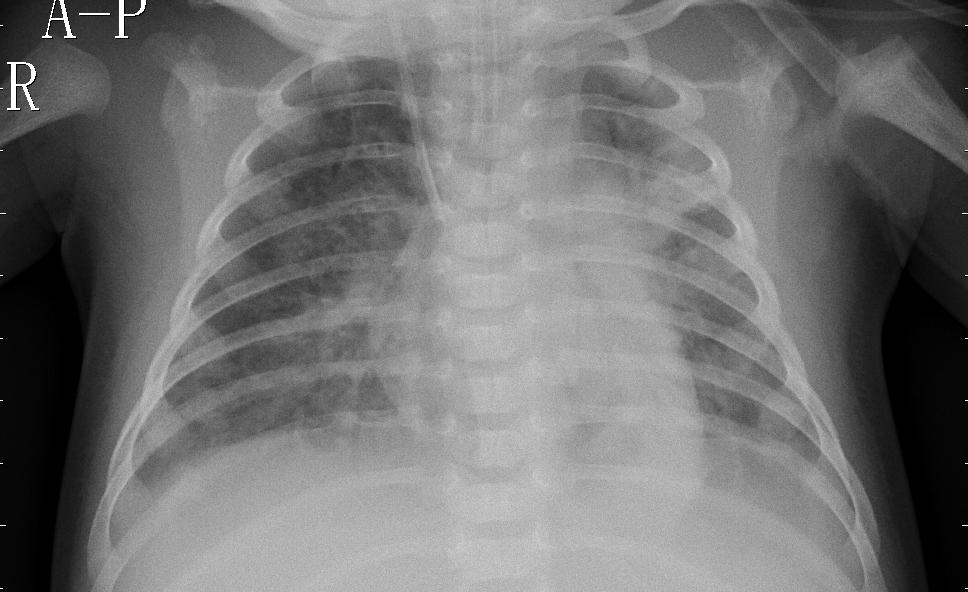

In [179]:
im

In [0]:
category, category_t, preciction = learn.predict(im)

In [182]:
category_t

tensor(1)

In [183]:
preciction

tensor([0.0025, 0.9975])

## Lets make our prediction

In [0]:
def plot_class_pred(learner, im_path, label_dict):
    im = open_image(im_path)
    category, category_t, preds = learner.predict(im)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(1)
    plt.imshow(im.data.detach().numpy().transpose(1, 2, 0))
    plt.gca().set_title('{0}, {1:.1f}%'.format(
        label_dict[int(category_t)],
        preds[int(category_t)].detach().numpy() * 100),
        color=("green")
    )
    return fig

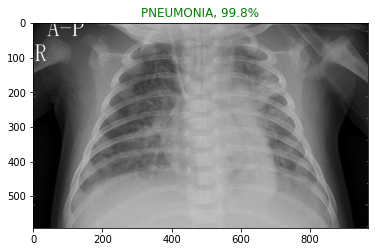

In [188]:
fig = plot_class_pred(learn, test_im2, label_dict)

## Why do this? Because you can save this for later purposes, like a presentation, or website

In [0]:
fig.savefig('prediction.png')